# Data Analysis for  WeRateDogs Twitter archive

## Table of Contents

[1 Introduction](#intro)

[2 Gathering Data](#2)

[3 Data Wrangling](#3)

[4 Explorary Data Analysis](#4)

[5 Conclusion and Limitations](#5)

<a id='#intro'></a>
## 1 Introduction
> Twitter is one of the most popular social media where people post and interact with messages known as "tweets". It can be really interesting to dive into the user accounts with large follower base. For this project, we analyze a specific user account "WeRateDogs". This a micro-community for dog lover to share funny and adorable photos of dogs. 

> This project consist of three sections, data gathering, data wrangling and explorary data analysis. The first two sections focus on generating clean and tidy dataset, then the dataset is export to .csv file and .db file for later analysis. The explorary data analysis uses the clean dataset derived from the previous sections and conduct analysis to provide insights on the trends of popular dogs based on retweet count, favorate count and image prediction results.

In [1]:
import numpy as np
import pandas as pd
import requests
import io
import os
import tweepy
from tweepy import OAuthHandler
import json
import timeit
import re
import datetime
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.linear_model import LinearRegression

<a id='2'></a>
## 2 Gathering Data
There are three data resources:
* Manually download: `twitter_archive_enhanced.csv`
* Derive from Udacity's servers: `image_predictions.tsv`
* Derive by Tweepy: `tweet_json.txt`

>`twitter_archive_enhanced.csv`: This file is downloaded manually and stores under the same path of this notebook for accessibility.

>`image_predictions.tsv`: This file is obtained using requests library in [section 2.1](need a html link here)

>`tweet_json.txt`: This file is obtained using requests library in [section 2.2](need a html link here)

### 2.1 Read `twitter_archive_enhanced.csv` from Udacity's servers 

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

### 2.1 Extract `image_predictions.tsv` from Udacity's servers 

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
urlData = requests.get(url).content
img_pred = pd.read_csv(io.StringIO(urlData.decode('utf-8')),sep='\t')

In [4]:
img_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 2.2 Extract data using twitter API

In [5]:
# read key value pairs from a json file.
with open('config.json') as f:
    config = json.load(f)

In [6]:
consumer_key = config['consumer_key']
consumer_secret = config['consumer_secret']
access_token = config['access_token']
access_secret = config['access_secret']

In [7]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [8]:
# start to retrieve data from twitter
# Since this takes more than 20 mins, check if the file exist or not.
# If the file exist, just skip this step.
if not os.path.exists("tweet_json.txt"):
    start = timeit.timeit() # set up a timer
    fails_dict={} # collect deleted ids
    count = 0 # get the processing status
    with open('tweet_json.txt', 'w') as outfile:
        for twt_id in img_pred['tweet_id']:
            try:
                tweet = api.get_status(twt_id,tweet_mode='extended',wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
                print('{} record success'.format(count),end="\r")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print('Fail',end="\r")
                fails_dict[twt_id] = e
                pass
            count += 1
else:
    print("File already exist!")

File already exist!


In [9]:
df_api = pd.DataFrame(columns=['id','display_text_range','retweet_count','favorite_count'])
with open('tweet_json.txt') as json_file:
    for line in json_file:
        data_str = json.loads(line)
        data_parse = pd.DataFrame.from_dict(data_str,orient="index")
        data_interested = data_parse[0][['id','display_text_range','retweet_count','favorite_count']]
        df_api = df_api.append(data_interested,ignore_index=True)

In [10]:
df_api.head()

,id,display_text_range,retweet_count,favorite_count
0,666020888022790149,"[0, 131]",466,2434
1,666029285002620928,"[0, 139]",42,121
2,666033412701032449,"[0, 130]",41,113
3,666044226329800704,"[0, 137]",133,274
4,666049248165822465,"[0, 120]",41,99


<a id='3'></a>
## 3 Data Wrangling
In the previous section, three tables are generated from different sources. In this sections, each table is carefully assessed and cleaned. The three dataframes are listed below:

* `twitter_archive`: retrieved from a .csv file
* `img_pred`: retrieved from Udacity server
* `df_api`: retrieved from twitter

### 3.1 Data Assesssing

#### 3.1.1 Data Assessing: `twitter_archive` table
**Quality issues**
* redundant information in `source` column.
* Erroneous datatypes(in_reply_to_status_id, in_reply_to_user_id, timestamp,retweet_status_id, retweet_status_user_id, retweet_status_timestamp, source,doggo,floofer,pupper,puppo)
* contains retweeted tweets (with retweet_user_id)
* more than 50% of NAN values in columns related `in_reply_to` and `retweeted_status`
* incorrect ratings (and change type to string)
* For some entries, key words 'doggo','floofer','pupper','puppo' exist in the text but did not record in the corresponding columns
* incorrect name for the dogs with name 'a' or 'None', some of them have a name and some of them do not have a name.
* Name column has uppercase letters.

**Tidniess issues**
* Text column contains multiple variables: text, rate and url
* ['doggo','floofer','pupper','puppo'] should be in one column.



In [11]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [12]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
twitter_archive.in_reply_to_status_id.value_counts()

6.671522e+17    2
8.562860e+17    1
8.131273e+17    1
6.754971e+17    1
6.827884e+17    1
               ..
8.482121e+17    1
6.715449e+17    1
6.936422e+17    1
6.849598e+17    1
7.331095e+17    1
Name: in_reply_to_status_id, Length: 77, dtype: int64

In [14]:
twitter_archive.retweeted_status_id.value_counts()

7.757333e+17    1
7.507196e+17    1
6.742918e+17    1
6.833919e+17    1
8.269587e+17    1
               ..
7.848260e+17    1
7.806013e+17    1
8.305833e+17    1
7.047611e+17    1
7.331095e+17    1
Name: retweeted_status_id, Length: 181, dtype: int64

In [15]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [16]:
for i in range(30,50):
    print('record index: '+ str(i) + '\n'+ twitter_archive.text[i] + '\nstage: ' + twitter_archive.puppo[i])

record index: 30
@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution
stage: None
record index: 31
This is Waffles. His doggles are pupside down. Unsure how to fix. 13/10 someone assist Waffles https://t.co/xZDA9Qsq1O
stage: None
record index: 32
RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo
stage: None
record index: 33
Viewer discretion advised. This is Jimbo. He will rip ur finger right h*ckin off. Other dog clearly an accessory. 12/10 pls pet with caution https://t.co/BuveP0uMF1
stage: None
record index: 34
This is Maisey. She fell asleep mid-excavation. Happens to the best of us. 13/10 would pat noggin approvingly https://t.co/tp1kQ8i9JF
stage: None
record index: 35
I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk
stage: None
record index: 36
RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5
stage: None
record index: 37

In [17]:
twitter_archive.retweeted_status_id.value_counts()

7.757333e+17    1
7.507196e+17    1
6.742918e+17    1
6.833919e+17    1
8.269587e+17    1
               ..
7.848260e+17    1
7.806013e+17    1
8.305833e+17    1
7.047611e+17    1
7.331095e+17    1
Name: retweeted_status_id, Length: 181, dtype: int64

In [18]:
twitter_archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [19]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [20]:
twitter_archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [21]:
twitter_archive['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [22]:
twitter_archive['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [23]:
twitter_archive['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [24]:
twitter_archive['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Geoff           1
Tobi            1
Chesterson      1
Aqua            1
Daniel          1
Name: name, Length: 957, dtype: int64

In [25]:
pd.set_option('display.max_colwidth', -1)
twitter_archive[twitter_archive.name == 'a'].text

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


56      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
649     Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq                           
801     Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn               
1002    This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW               
1004    Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R                 
1017    This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2                     
1049    This is 

####  3.1.2 Data Assessing: `img_pred` table
This table is pretty clean without any issues for now.

In [26]:
img_pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [27]:
img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [28]:
img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


####  3.1.3 Data Assessing: `df_api` table
**Quality issues**
* '[]' and starting point of the range for `display_text_range`
* Erroneous datatypes `display_text_range`, `retweet_count` and `favorite_count`


In [29]:
df_api

,id,display_text_range,retweet_count,favorite_count
0,666020888022790149,"[0, 131]",466,2434
1,666029285002620928,"[0, 139]",42,121
2,666033412701032449,"[0, 130]",41,113
3,666044226329800704,"[0, 137]",133,274
4,666049248165822465,"[0, 120]",41,99
...,...,...,...,...
2054,891327558926688256,"[0, 138]",8555,38021
2055,891689557279858688,"[0, 79]",7926,39825
2056,891815181378084864,"[0, 121]",3808,23699
2057,892177421306343426,"[0, 138]",5752,31449


In [30]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2059 non-null   object
 1   display_text_range  2059 non-null   object
 2   retweet_count       2059 non-null   object
 3   favorite_count      2059 non-null   object
dtypes: object(4)
memory usage: 64.5+ KB


### 3.2 Data Cleaning

In [31]:
twitter_archive_clean = twitter_archive.copy()
img_pred_clean = img_pred.copy()
df_api_clean = df_api.copy()

**Issue:** table `twitter_archive_clean` redundant information in `source` column

**Define:** remove the html tags using regular expression

In [32]:
twitter_archive_clean = twitter_archive_clean.replace({'source': r'<[^>]*>'}, {'source': ''}, regex=True)

In [33]:
# test
twitter_archive_clean.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene    91  
Twitter Web Client     33  
TweetDeck              11  
Name: source, dtype: int64

**Issue:** * Erroneous datatypes(in_reply_to_status_id, in_reply_to_user_id, timestamp,retweet_status_id, retweet_status_user_id, retweet_status_timestamp)

**Define:** Convert ids to 'int64', timestamps to datetime. Replace Nan as 0.

In [34]:
# replace nan as 0 and convert id related columns to 'int64' 
ids = ['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id']
twitter_archive_clean[ids] = twitter_archive_clean[ids].fillna(0).astype('int64')

In [35]:
# convert string to timestamp for timestamp related columns
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)
twitter_archive_clean.retweeted_status_timestamp = pd.to_datetime(twitter_archive_clean.retweeted_status_timestamp)

In [36]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       2356 non-null   int64              
 2   in_reply_to_user_id         2356 non-null   int64              
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         2356 non-null   int64              
 7   retweeted_status_user_id    2356 non-null   int64              
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

**Issue:** contains retweeted tweets and reply tweet (with retweeted_user_id, in_reply_to_status_id)

**Define:** extract rows with 'retweeted_status_id' and 'in_reply_to_status_id' equal to 0.

In [37]:
twitter_archive_clean = twitter_archive_clean.query('retweeted_status_id == 0 and in_reply_to_status_id==0')

In [38]:
twitter_archive_clean = twitter_archive_clean.reset_index(drop=True)

In [39]:
twitter_archive_clean.retweeted_status_id.value_counts()

0    2097
Name: retweeted_status_id, dtype: int64

**Issue:** table `twitter_archive_clean` More than 50% of NAN values in columns related `in_reply_to` and `retweeted_status`.

**Define**: since these infomation is trivial for the later analysis, these columns are dropped.

In [40]:
labels =  ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']
twitter_archive_clean = twitter_archive_clean.drop(columns = labels, axis = 1 )

In [41]:
# test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

**Issue:** table `twitter_archive_clean`, `text` column contains multiple variables (text, rate, url)

**Define:** add a new column `Full_text` to store text, extract the text using regular expression

In [42]:
twitter_archive_clean['url'] = twitter_archive_clean.text.str.extract('(http.*)')
twitter_archive_clean['rate'] = twitter_archive_clean.text.str.extract('(\d+.?\d\/\d+)')

In [43]:
twitter_archive_clean['Full_text'] = twitter_archive_clean.text.str.replace('(http.*)','').str.replace('(\d+\/\d+)','')

In [44]:
# test I
twitter_archive_clean[['text','url','rate','Full_text']].iloc[30:50]

,text,url,rate,Full_text
30,Viewer discretion advised. This is Jimbo. He will rip ur finger right h*ckin off. Other dog clearly an accessory. 12/10 pls pet with caution https://t.co/BuveP0uMF1,https://t.co/BuveP0uMF1,12/10,Viewer discretion advised. This is Jimbo. He will rip ur finger right h*ckin off. Other dog clearly an accessory. pls pet with caution
31,This is Maisey. She fell asleep mid-excavation. Happens to the best of us. 13/10 would pat noggin approvingly https://t.co/tp1kQ8i9JF,https://t.co/tp1kQ8i9JF,13/10,This is Maisey. She fell asleep mid-excavation. Happens to the best of us. would pat noggin approvingly
32,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,https://t.co/gzLHboL7Sk,14/10,I have a new hero and his name is Howard.
33,Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happenings. 13/10 https://t.co/44ItaMubBf,https://t.co/44ItaMubBf,13/10,Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happenings.
34,"This is Earl. He found a hat. Nervous about what you think of it. 12/10 it's delightful, Earl https://t.co/MYJvdlNRVa",https://t.co/MYJvdlNRVa,12/10,"This is Earl. He found a hat. Nervous about what you think of it. it's delightful, Earl"
35,This is Lola. It's her first time outside. Must test the earth and taste the atmosphere. 13/10 you're doing great Lola https://t.co/74TKAUsLkO,https://t.co/74TKAUsLkO,13/10,This is Lola. It's her first time outside. Must test the earth and taste the atmosphere. you're doing great Lola
36,This is Kevin. He's just so happy. 13/10 what is your secret Kevin https://t.co/1r4MFCbCX5,https://t.co/1r4MFCbCX5,13/10,This is Kevin. He's just so happy. what is your secret Kevin
37,"I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC",https://t.co/vvBOcC2VdC,14/10,"I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. (IG: itselizabethgales)"
38,OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LITTLE BARKOUR HE'S SUPER SORRY 13/10 WOULD FORGIVE IMMEDIATE https://t.co/uF3pQ8Wubj,https://t.co/uF3pQ8Wubj,13/10,OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LITTLE BARKOUR HE'S SUPER SORRY WOULD FORGIVE IMMEDIATE
39,Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,https://t.co/YSI00BzTBZ,12/10,Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. for dangerously dapper doggo


In [45]:
# test II
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
 12  url                 2094 non-null 

**Issue:** table `twitter_archive_clean`, incorrect rating contains float number (row 45, numerator = 13.5) (and change type to float)

**Define:** use split to retrieve numerator and denominator from `rate` assign the corresponding values to `rating_numerator` and `rating_denominator`. Then convert the string to 'float64'

In [46]:
twitter_archive_clean['rating_numerator'] , twitter_archive_clean['rating_denominator'] = twitter_archive_clean.rate.str.split(pat = '/').str

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [59]:
test = twitter_archive_clean.copy()
index = test[test.rating_numerator == '3 1'].index

In [60]:
twitter_archive_clean.rate[index[0]] = '9/10'
twitter_archive_clean.rating_numerator[index[0]] = '9'
twitter_archive_clean.rating_denominator[index[0]] = '10'

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
test[test.rating_numerator == '3 1']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,url,rate,Full_text
2076,666287406224695296,2015-11-16 16:11:11+00:00,Twitter for iPhone,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,3 1,2,an,https://t.co/d9NcXFKwLv,3 1/2,This is an Albanian 3 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar.


In [63]:
twitter_archive_clean[['rating_numerator','rating_denominator']] = twitter_archive_clean[['rating_numerator','rating_denominator']].astype('float64')

In [64]:
# test
twitter_archive_clean[['rating_numerator','rating_denominator']].iloc[42]

rating_numerator      13.0
rating_denominator    10.0
Name: 42, dtype: float64

**Issue:** table `twitter_archive_clean`, for some entries key words ['doggo','floofer','pupper','puppo'] exist in the text but did not record in the corresponding columns

**Define:** use str.extract to extract the entries containing the key words('doggo','floofer','pupper','puppo') in `Full_text` column. The key words are defined by regular expression.

In [65]:
pats = {'doggo':'[Dd][Oo][Gg][Gg][Oo]','floofer':'[Ff][Ll][Oo][Oo][Ff][Ee][Rr]',
       'pupper':'[Pp][Uu][Pp][Pp][Ee][Rr]', 'puppo':'[Pp][Uu][Pp][Pp][Oo]'}
for pat in pats.keys():
    pattern = '('+ pats[pat] + ')'
    twitter_archive_clean[pat] = twitter_archive_clean.Full_text.str.extract(pattern)
    twitter_archive_clean[pat].fillna('',inplace = True)

In [66]:
twitter_archive_clean.doggo.value_counts(), twitter_archive_clean.floofer.value_counts()

(         2006
 doggo    83  
 Doggo    7   
 DOGGO    1   
 Name: doggo, dtype: int64,
            2087
 Floofer    6   
 floofer    4   
 Name: floofer, dtype: int64)

In [67]:
twitter_archive_clean.pupper.value_counts(), twitter_archive_clean.puppo.value_counts()

(          1842
 pupper    243 
 Pupper    8   
 PUPPER    4   
 Name: pupper, dtype: int64,
          2067
 puppo    29  
 Puppo    1   
 Name: puppo, dtype: int64)

**Issue:** table `twitter_archive_clean`, ['doggo','floofer','pupper','puppo'] should be in one column.`['doggo','floofer','pupper','puppo']` 

**Define:** lowercase all the strings within the ['doggo','floofer','pupper','puppo'] columns, and  concatenate four columns into one column `stage`. If one entry contains multiple stage, reassign the stage as 'multiple stage'.

In [68]:
twitter_archive_clean.stage = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [69]:
twitter_archive_clean.stage = twitter_archive_clean.stage.str.lower()

In [70]:
twitter_archive_clean.stage.value_counts()

                1723
pupper          246 
doggo           79  
puppo           28  
floofer         9   
doggopupper     9   
doggopuppo      2   
doggofloofer    1   
dtype: int64

In [71]:
multiple_stage = ['doggopupper','doggopuppo','doggofloofer']
for row in range(len(twitter_archive_clean)):
    if twitter_archive_clean.stage[row] in multiple_stage:
        twitter_archive_clean.stage[row] = 'multiple stage'

In [72]:
twitter_archive_clean.drop(columns = ['doggo','floofer','pupper','puppo'],inplace=True)

In [73]:
twitter_archive_clean.stage.value_counts()

                  1723
pupper            246 
doggo             79  
puppo             28  
multiple stage    12  
floofer           9   
dtype: int64

**Issue:** table `twitter_archive_clean`, `name` column contains several incorrect names (assigned 'a')

**Define:** use str.contains to find the correct names and replace the incorrected names("a" and "None").

In [74]:
# GET ALL CORRECT NAMES
# select 
nan_name = twitter_archive_clean.query('name == "a" or name == "None"')
# pattern 1: named xxx, pattern 2: name is xxx
corrected_names = pd.DataFrame()
patterns = ['(named\s(\w+))','(name\sis\s(\w+))']
for pat in patterns:
    names = nan_name.Full_text.str.extract(pat)[1].dropna().to_frame()
    corrected_names = corrected_names.append(names)

In [75]:
# reset the indices and rename the column in a more decriptive way.
corrected_names = corrected_names.reset_index()
corrected_names = corrected_names.rename(columns = {'index':'ind',1:'cor_name'})

In [76]:
twitter_archive_clean.name[603]

'Finley'

In [77]:
# replace the incorrect names with the correct name.
length = len(corrected_names)
for i in range(length):
    twitter_archive_clean.name[corrected_names.ind[i]] = corrected_names.cor_name[i]

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [78]:
# text
a = twitter_archive_clean.query('name == "a" or name == "None" and Full_text.str.contains("name|call")',engine='python')

a[['name','Full_text']].sample(10)

,name,Full_text
1145,a,This is a Wild Tuscan Poofwiggle. Careful not to startle. Rare tongue slip. One eye magical. would def pet
1833,None,I would do radical things in the name of Dog God. I'd believe every word in that book.
1499,a,Guys this really needs to stop. We've been over this way too many times. This is a giraffe. We only rate dogs..
1633,a,C'mon guys. We've been over this. We only rate dogs. This is a cow. Please only submit dogs. Thank you......
2095,a,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. would walk the shit out of
1899,a,This is a brave dog. Excellent free climber. Trying to get closer to God. Not very loyal though. Doesn't bark.
2046,None,My goodness. Very rare dog here. Large. Tail dangerous. Kinda fat. Only eats leaves. Doesn't come when called
1159,a,"""Pupper is a present to world. Here is a bow for pupper."" precious as hell"
1955,a,Here is a horned dog. Much grace. Can jump over moons (dam!). Paws not soft. Bad at barking. can still pet tho
2094,a,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. would cuddle af


**Issue:** table `twitter_archive_clean`, contains retweeted tweets (without image)

**Define:** merge table `img_pred_clean` to `twitter_archive_clean`.


In [79]:
twitter_archive_clean = twitter_archive_clean.merge(img_pred_clean,left_on='tweet_id',right_on='tweet_id')

In [80]:
# test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   int64              
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1567 non-null   float64            
 6   rating_denominator  1567 non-null   float64            
 7   name                1971 non-null   object             
 8   url                 1971 non-null   object             
 9   rate                1567 non-null   object             
 10  Full_text           1971 non-null   object             
 11  jpg_url             1971 non-null   object             
 12  img_num             1971 non-null 

**Issue:** table `df_api`, column `display_text_range` have '[]' and starting point of the range.

**Define:** extract the length of the text from list objects.

In [81]:
df_api_clean['text_len'] = pd.DataFrame({'text_len':df_api_clean.display_text_range[i][1]} for i in range(len(df_api_clean)))

In [82]:
df_api_clean.head()

,id,display_text_range,retweet_count,favorite_count,text_len
0,666020888022790149,"[0, 131]",466,2434,131
1,666029285002620928,"[0, 139]",42,121,139
2,666033412701032449,"[0, 130]",41,113,130
3,666044226329800704,"[0, 137]",133,274,137
4,666049248165822465,"[0, 120]",41,99,120


In [83]:
df_api_clean = df_api_clean.rename(columns={'id':'tweet_id'})

In [84]:
df_api_clean = df_api_clean.drop('display_text_range',axis = 1)

In [85]:
df_api_clean.head()

,tweet_id,retweet_count,favorite_count,text_len
0,666020888022790149,466,2434,131
1,666029285002620928,42,121,139
2,666033412701032449,41,113,130
3,666044226329800704,133,274,137
4,666049248165822465,41,99,120


**Issue:** Erroneous datatypes `tweet_id`, `retweet_count` and `favorite_count`.

**Define:** convert strings to int64 using `astype()`


In [86]:
df_api_clean.retweet_count = df_api_clean.retweet_count.astype('int64')
df_api_clean.favorite_count = df_api_clean.favorite_count.astype('int64')
df_api_clean.tweet_id = df_api_clean.tweet_id.astype('int64')

In [87]:
# test
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2059 non-null   int64
 1   retweet_count   2059 non-null   int64
 2   favorite_count  2059 non-null   int64
 3   text_len        2059 non-null   int64
dtypes: int64(4)
memory usage: 64.5 KB


merge `df_api_clean` table to `twitter_archive_clean` table 

In [88]:
# merge df_api_clean and twitter_archive_clean to twitter_clean
twitter_clean = twitter_archive_clean.copy()

In [89]:
twitter_clean = twitter_clean.merge(df_api_clean,left_on='tweet_id',
    right_on='tweet_id')

In [90]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1964 non-null   int64              
 1   timestamp           1964 non-null   datetime64[ns, UTC]
 2   source              1964 non-null   object             
 3   text                1964 non-null   object             
 4   expanded_urls       1964 non-null   object             
 5   rating_numerator    1560 non-null   float64            
 6   rating_denominator  1560 non-null   float64            
 7   name                1964 non-null   object             
 8   url                 1964 non-null   object             
 9   rate                1560 non-null   object             
 10  Full_text           1964 non-null   object             
 11  jpg_url             1964 non-null   object             
 12  img_num             1964 non-null 

**Issue:** table `twitter_archive_clean`, contains retweeted tweets (RT, and identical retweet counts)

**Define:** remove rows that `Full_text` column with pattern: RT @xxxx

In [91]:
RT = (twitter_clean.Full_text.str.contains('RT\s@\w+') == True)
twitter_clean[RT]['Full_text']

Series([], Name: Full_text, dtype: object)

In [92]:
RT_ind = twitter_clean[RT].index

In [93]:
twitter_clean = twitter_clean.drop(RT_ind,axis=0).reset_index()

In [94]:
# test
sum(twitter_clean.Full_text.str.contains('RT\s@\w+') == True)

0

### 3.3 Export clean data 

In [95]:
# Drop columns that we are not interested in.
drop_columns = ['text','expanded_urls','url','rate','jpg_url']
twitter_clean.drop(drop_columns,axis=1,inplace=True)

In [96]:
# test
twitter_clean.head()

,index,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,Full_text,img_num,p1,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,text_len
0,0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,13.0,10.0,Phineas,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut.,1,orange,...,False,bagel,0.085851,False,banana,0.076110,False,7759,36489,85
1,1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,13.0,10.0,Tilly,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit.",1,Chihuahua,...,True,Pekinese,0.090647,True,papillon,0.068957,True,5752,31449,138
2,2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,12.0,10.0,Archie,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike.,1,Chihuahua,...,True,malamute,0.078253,True,kelpie,0.031379,True,3808,23699,121
3,3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,13.0,10.0,Darla,This is Darla. She commenced a snooze mid meal. happens to the best of us,1,paper_towel,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7926,39825,79
4,4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,12.0,10.0,Franklin,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. #BarkWeek",2,basset,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8555,38021,138


In [97]:
# create a csv file for clean data.
twitter_clean.to_csv('twitter_archive_master.csv', sep=',', encoding='utf-8',index=False);

In [98]:
# create a sqlite database for clean data.
engine = create_engine('sqlite:///twitter_archive_master.db', echo=False)
twitter_clean.to_sql('twitter_archive_master', con=engine,if_exists='replace')

<a id='4'></a>
## 4 Exploratory Data Analysis
In this section, we use the clean data to answer the following questions:
* Which tweet has the most retweets and/or the most likes?
* Which breed of dogs has the most tweets based on the predictions, what about the trend of breeds?
* What is the trend of average content length, retweet counts and favorite counts?
* Any relationship beween retweet count and favorite count?

In [99]:
df = pd.read_csv('twitter_archive_master.csv')

In [100]:
df.head()

,index,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,Full_text,img_num,p1,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,text_len
0,0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,13.0,10.0,Phineas,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut.,1,orange,...,False,bagel,0.085851,False,banana,0.076110,False,7759,36489,85
1,1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,13.0,10.0,Tilly,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit.",1,Chihuahua,...,True,Pekinese,0.090647,True,papillon,0.068957,True,5752,31449,138
2,2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,12.0,10.0,Archie,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike.,1,Chihuahua,...,True,malamute,0.078253,True,kelpie,0.031379,True,3808,23699,121
3,3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,13.0,10.0,Darla,This is Darla. She commenced a snooze mid meal. happens to the best of us,1,paper_towel,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7926,39825,79
4,4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,12.0,10.0,Franklin,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. #BarkWeek",2,basset,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8555,38021,138


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1964 entries, 0 to 1963
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               1964 non-null   int64  
 1   tweet_id            1964 non-null   int64  
 2   timestamp           1964 non-null   object 
 3   source              1964 non-null   object 
 4   rating_numerator    1560 non-null   float64
 5   rating_denominator  1560 non-null   float64
 6   name                1964 non-null   object 
 7   Full_text           1964 non-null   object 
 8   img_num             1964 non-null   int64  
 9   p1                  1964 non-null   object 
 10  p1_conf             1964 non-null   float64
 11  p1_dog              1964 non-null   bool   
 12  p2                  1964 non-null   object 
 13  p2_conf             1964 non-null   float64
 14  p2_dog              1964 non-null   bool   
 15  p3                  1964 non-null   object 
 16  p3_con

In [102]:
df_clean = df.copy()

### 4.1 Data clean

Based on the questions mentioned above, table `df` are modified by the following steps:
* **Drop columns related with prediction 2 and prediction 3**: Since prediction 1 has the highest confidence, prediction 1 is used as the final results.
* **Create new columns `Month`,`DayofWeek`,`Time`**：month, day of week and time are extracted and stored individually to study different trends over time.
* **create rate ratio**: rating_numerator divides rating_denominator

#### 4.1.1 Drop columns related with prediction 2 and prediction 3

In [103]:
drop_cols= ['p2','p2_conf','p2_dog','p3','p3_conf','p3_dog']
df_clean.drop(drop_cols,axis=1,inplace = True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1964 entries, 0 to 1963
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               1964 non-null   int64  
 1   tweet_id            1964 non-null   int64  
 2   timestamp           1964 non-null   object 
 3   source              1964 non-null   object 
 4   rating_numerator    1560 non-null   float64
 5   rating_denominator  1560 non-null   float64
 6   name                1964 non-null   object 
 7   Full_text           1964 non-null   object 
 8   img_num             1964 non-null   int64  
 9   p1                  1964 non-null   object 
 10  p1_conf             1964 non-null   float64
 11  p1_dog              1964 non-null   bool   
 12  retweet_count       1964 non-null   int64  
 13  favorite_count      1964 non-null   int64  
 14  text_len            1964 non-null   int64  
dtypes: bool(1), float64(3), int64(6), object(5)
memory usag

#### 4.1.2 create new columns `Date`,`Month`, `DayofWeek`, `Time`

In [104]:
# create a year column:
df_clean.timestamp = pd.to_datetime(df_clean.timestamp)

In [105]:
df_clean.timestamp.min(), df_clean.timestamp.max()

(Timestamp('2015-11-15 22:32:08+0000', tz='UTC'),
 Timestamp('2017-08-01 16:23:56+0000', tz='UTC'))

In [106]:
df_clean['Date'] = df_clean.timestamp.dt.date

In [107]:
df_clean['Month'] = df_clean.timestamp.dt.month

In [108]:
df_clean['DayofWeek'] = df_clean.timestamp.dt.dayofweek

In [109]:
df_clean['PartsOfDay'] = df_clean.timestamp.dt.hour

In [110]:
df_clean[['Month','DayofWeek','PartsOfDay']].describe()

,Month,DayofWeek,PartsOfDay
count,1964.000000,1964.000000,1964.000000
mean,7.170061,2.839104,9.732179
std,4.119286,2.005235,8.627077
min,1.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000
50%,7.000000,3.000000,4.000000
75%,11.000000,5.000000,18.000000
max,12.000000,6.000000,23.000000


#### 4.1.3 create new column `rate_ratio`

In [111]:
df_clean['rate_ratio'] = df_clean.rating_numerator/df_clean.rating_denominator

In [112]:
df_clean['rate_ratio'].describe()

count    1560.000000
mean     1.287358   
std      4.589877   
min      0.900000   
25%      1.000000   
50%      1.100000   
75%      1.200000   
max      177.600000 
Name: rate_ratio, dtype: float64

### 4.2 Data analysis and Visualization 

#### 4.2.0 General analysis

In [113]:
df_clean[['retweet_count','favorite_count']].describe()

,retweet_count,favorite_count
count,1964.000000,1964.000000
mean,2492.574847,8396.269348
std,4453.491562,12336.457384
min,11.000000,72.000000
25%,556.750000,1795.750000
50%,1203.500000,3800.500000
75%,2842.750000,10451.750000
max,78486.000000,157726.000000


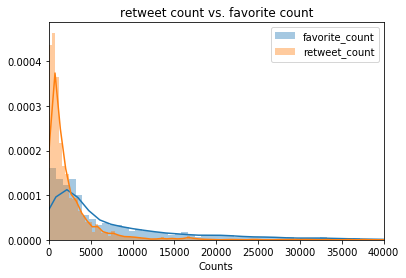

In [114]:
ax = sns.distplot(df_clean['favorite_count'],bins=200)
ax = sns.distplot(df_clean['retweet_count'],bins =200)
ax.set_xlim(0,40000)
plt.xlabel('Counts')
plt.title('retweet count vs. favorite count')
plt.legend(['favorite_count','retweet_count']);

The favorite and retweet counts graph shows that the favorite count is higher than retweet_count in general. One proof is that most of tweets are retweeted less than 5000 times(located with in the interval 0-5000 counts), while tweets gained more likes (more tweets in the interval >5000 counts).

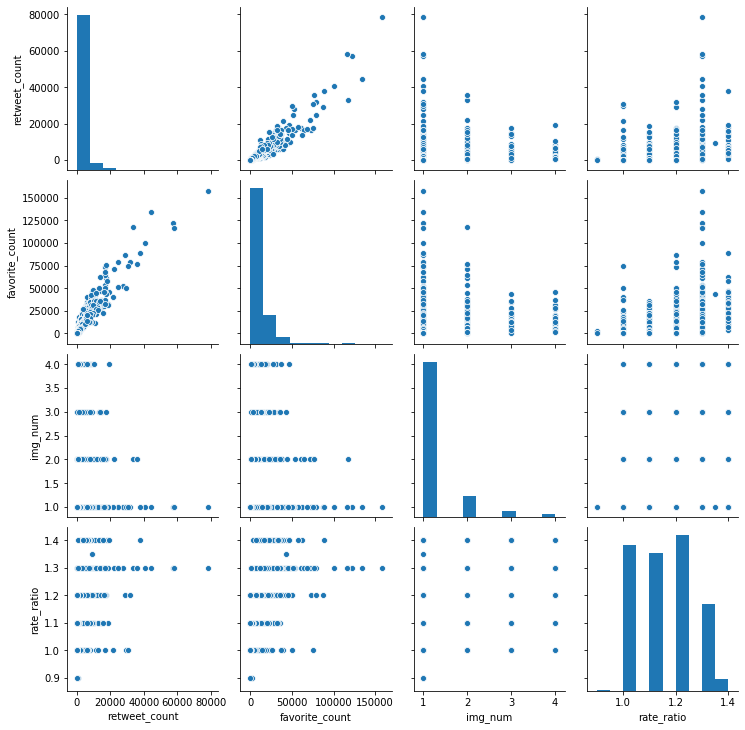

In [115]:
pair = df_clean[['retweet_count','favorite_count','p1','img_num','rate_ratio']]
pair = pair[pair.rate_ratio <= 2]
pair = pair.dropna()
sns.pairplot(pair);

The retweet count and favorite count is highly correlated. The rate ratio might overestimate the images based on the retweet count vs rate ratio and favorite count vs rate ratio. The more images in the tweet, the more likely it has a higher rate while has less chance to be retweeted or like.

#### 4.2.1  Which tweet has the most retweets and/or the most likes?

In [116]:
def top_10(df,column):
    top_10 = df.sort_values(by=[column],ascending=False)[[column,
                                           'Full_text','p1']].head(10)
    return top_10

In [117]:
def plot(ax,xlabel,ylabel,title,labels,leg_labels = None):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    ax.set_xticklabels(labels,rotation=70);
    if leg_labels:
        plt.legend(leg_labels);

In [118]:
top_10(df_clean,'retweet_count')

,retweet_count,Full_text,p1
763,78486,Here's a doggo realizing you can stand in a pool. enlightened af (vid by Tina Conrad),Labrador_retriever
798,58202,Here's a doggo blowing bubbles. It's downright legendary. would watch on repeat forever (vid by Kent Duryee),Eskimo_dog
393,57246,This is Stephan. He just wants to help. such a good boy,Chihuahua
302,44250,Here's a super supportive puppo participating in the Toronto #WomensMarch today.,Lakeland_terrier
58,40903,This is Duddles. He did an attempt. someone help him (vid by Georgia Felici),English_springer
326,37744,This is Bo. He was a very good First Doggo. would be an absolute honor to pet,standard_poodle
395,35797,"""Good afternoon class today we're going to learn what makes a good boy so good""",Arabian_camel
107,33221,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. such passion, much tender",French_bulldog
1402,31633,This made my day. please enjoy,swing
1460,30582,This is Kenneth. He's stuck in a bubble. hang in there Kenneth,bubble


In [119]:
top_10(df_clean,'favorite_count')

,favorite_count,Full_text,p1
763,157726,Here's a doggo realizing you can stand in a pool. enlightened af (vid by Tina Conrad),Labrador_retriever
302,134376,Here's a super supportive puppo participating in the Toronto #WomensMarch today.,Lakeland_terrier
393,121747,This is Stephan. He just wants to help. such a good boy,Chihuahua
107,117330,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. such passion, much tender",French_bulldog
798,116437,Here's a doggo blowing bubbles. It's downright legendary. would watch on repeat forever (vid by Kent Duryee),Eskimo_dog
58,100055,This is Duddles. He did an attempt. someone help him (vid by Georgia Felici),English_springer
326,88869,This is Bo. He was a very good First Doggo. would be an absolute honor to pet,standard_poodle
133,87243,We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you...,Angora
92,79103,This is Zoey. She really likes the planet. Would hate to see willful ignorance and the denial of fairly elemental science destroy it.,golden_retriever
1402,79020,This made my day. please enjoy,swing


In [120]:
fr_ratio = top_10(df_clean,'favorite_count').favorite_count/top_10(df_clean,'retweet_count').retweet_count
fr_ratio

58      2.446153
92     NaN      
107     3.531802
133    NaN      
302     3.036746
326     2.354520
393     2.126734
395    NaN      
763     2.009607
798     2.000567
1402    2.498024
1460   NaN      
dtype: float64

In [121]:
# favorite to retweet count ratio.
fr_ratio.mean()

2.5005190892659654

A Labrador retriever has gained the most retweets (78486) and favorite counts (157726). Eight tweets are in both ranking. In general, the favorite count is the 2.5 times the same as retweet count for these eight tweets. A more dedicate study on the relationship between favorite count and retweet counts is conducted in the following sections.

#### 4.2.2 Which breed of dogs have the most tweets based on the predictions?

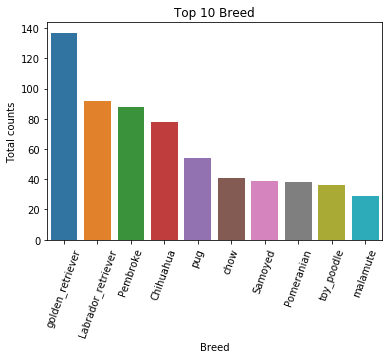

In [122]:
top10_breed = df_clean.p1.value_counts().head(10)
ax = sns.barplot(x = top10_breed.index, y = top10_breed.values)
plot(ax,'Breed','Total counts','Top 10 Breed',top10_breed.index)

Top 10 breeds are golden retriever, labrador retriever, pembroke, Chihuahua, pug, chow, Samoyed, Pomeranian, toy poodle and malamute.

#### 4.2.3 What is the trend of average content length, retweet_count and favorite_count?

In [123]:
# barplot and lineplot
def time_plot(pltype,series,stats,axes=None):
    series_mean = df_clean.groupby(series)[stats].mean()
    if pltype == 'bar':
        ax = sns.barplot(x = series_mean.index, y = series_mean.values,ax=axes)
        plot(ax,series,'AVG ' + stats,'AVG '+ stats + ' by ' + series,series_mean.index)
    if pltype == 'line':
        ax = sns.lineplot(x = series_mean.index, y = series_mean.values,ax =axes)
        plot(ax,'Date','AVG ' + stats,'AVG '+ stats + ' by ' + series,series_mean.index[1:-1:50])
        rolling_mean = series_mean.rolling(window=30).mean()
        plt.plot(rolling_mean, color='orange');

In [124]:
def plot_compare(series,win):
    fig, ax1 = plt.subplots()
    for stats in ['retweet_count','favorite_count']:
        series_mean = df_clean.groupby(series)[stats].mean()
        rolling_mean = series_mean.rolling(window=win).mean()
        plt.plot(rolling_mean);
    plt.xticks(rotation=70)
    plt.legend(labels = ['retweet_count','favorite_count'],loc='upper left')
        
    ax2 = ax1.twinx()
    
    color = 'tab:red'
    stats = 'text_len'
    series_mean = df_clean.groupby(series)[stats].mean()
    rolling_mean = series_mean.rolling(window=win).mean()
    ax2.set_ylabel('text_len', color=color)
    ax2.plot(rolling_mean,color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend(labels = ['text_len'],loc='upper right')

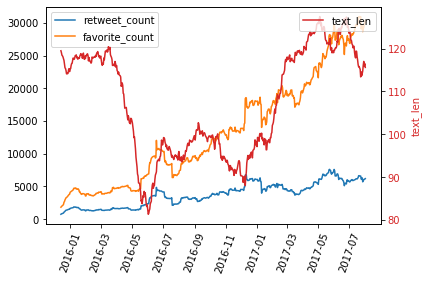

In [125]:
# General trend of retweet count, favorite count and text length. Moving average of 30 days
stats = 'Date'
plot_compare(stats,30)

If we look at the general trend in the entire time period, both retweet count and favorite count follows the same pattern that increases steadily from 2015/12/15 to 2017/8/1, while the favorite count follows a higher growth rate. When it comes to text length, the trend is more complex. It seems people tending to write longer messages during winter and spring and less in the summer and autumn.

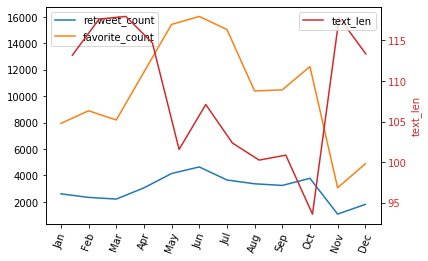

In [126]:
stats = 'Month'
plot_compare(stats,1)
plt.xticks(np.arange(13),calendar.month_abbr[0:13]);

The figure above shows the general trends for different months. For text length, the trend is consistent with the trend in the previous figure that people write more in the cold months and less in the warm months

Interestingly, opposite to the trend of text length, people tend to retweet and like more in the summer and less in the winter.

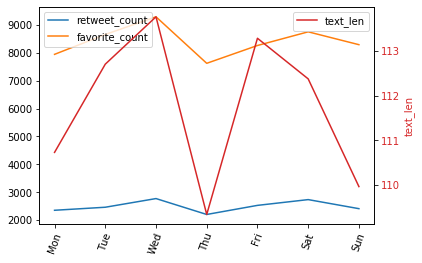

In [127]:
stats = 'DayofWeek'
plot_compare(stats,1)
plt.xticks(np.arange(7),calendar.day_abbr[0:7]);

When it comes to different days in a week, three metrics follow a quite similar pattern that peaks on Wednesdays and Fridays, valleys on Thursdays.

#### 4.2.4 Any relationship between columns?

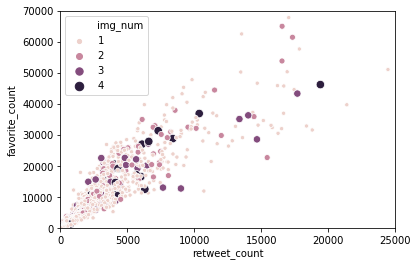

In [128]:
ax = sns.scatterplot(x="retweet_count", y="favorite_count",
                     hue="img_num", size="img_num",
                     data=df_clean)
ax.set_xlim(0,25000)
ax.set_ylim(0,70000);

The scatter plot shows that favorite count and retweet counts has a positive relationship, however, these two variables are heteroscedastic. Heteroscedasticity leads to biased standard errors, therefore it reduce the precision of the coefficient estimates. Here we logarithmize data to correct the draw data.

Unsupervised learning - linear regression

In [129]:
unbias_df = np.log(df_clean[['retweet_count','favorite_count']])

In [130]:
np.sum(unbias_df.isnull())

retweet_count     0
favorite_count    0
dtype: int64

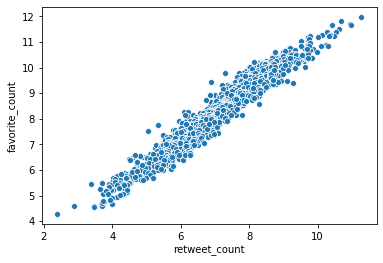

In [131]:
# corrected data
ax = sns.scatterplot(x="retweet_count", y="favorite_count",
                     data=unbias_df)

In [132]:
#  linear approach to modeling the relationship betweet two counts
X = np.array(unbias_df.retweet_count).reshape(-1,1)
y = np.array(unbias_df.favorite_count).reshape(-1,1)
reg = LinearRegression().fit(X, y)
reg.score(X, y), reg.coef_, reg.intercept_

(0.9377090808020956, array([[1.01320379]]), array([1.10532914]))

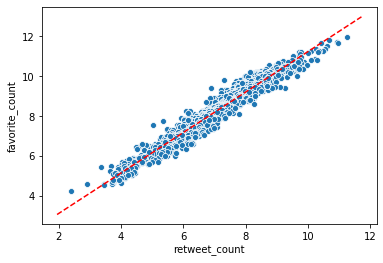

In [133]:
# use the underlying relationship
ax = sns.scatterplot(x="retweet_count", y="favorite_count",
                     data=unbias_df)
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color='red')
abline(reg.coef_[0][0],reg.intercept_[0])


It is obvious that retweet count and favorite count are positively related. We can use the red line to predict one of the counts if the other is given.

 <a id='5'></a>
 ## 5 Conclusion and Limitations

According to the analysis, among all breeds golden retriever has the most retweets and favorite. However, the top 1 favorite and retweeted tweet is about a Labrador retriever doggo. 

The pattern and trend study shows that people prefer to like a tweet more than retweet it. When it is cold outside, people tend to retweet and/or like more tweets and the total length of tweets tends to be short. In contrast, in the summer people prone to write more and retweet less.

The retweet count and the favorite count is highly related. A regression line can be used to predict the retweet count based on the favorite count, vice versa.

Even though heteroscedasticity is largely corrected by the logrithmization process, the scatter plot shows that the standard deviation is not constant. This phenomenon leads to a slightly biased confidence interval of the computed coefficient and interception.